In [1]:
pip install --upgrade transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install bitsandbytes


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/spati/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using device: cuda
Label Map: {'Decision': 0, 'Post-Purchase': 1, 'Awareness': 2, 'Consideration': 3}
Added padding token '[PAD]' to tokenizer.


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/local_scratch/slurm.1723009/ipykernel_4028131/3801307676.py:140: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kerne

Starting training...


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.546506,0.455128,0.378295,0.656611,0.455128
2,No log,0.531055,0.826923,0.830644,0.838041,0.826923
3,No log,0.368570,0.897436,0.884494,0.875489,0.897436
4,No log,0.270631,0.910256,0.906796,0.906288,0.910256
5,No log,0.298072,0.878205,0.864667,0.865379,0.878205
6,No log,0.229192,0.929487,0.926615,0.924403,0.929487


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, 

Evaluation Metrics: {'eval_loss': 0.22919194400310516, 'eval_accuracy': 0.9294871794871795, 'eval_f1': 0.9266146085114918, 'eval_precision': 0.9244031830238726, 'eval_recall': 0.9294871794871795, 'eval_runtime': 0.3599, 'eval_samples_per_second': 433.511, 'eval_steps_per_second': 5.558, 'epoch': 6.8}


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

     Decision       1.00      0.97      0.99        70
Post-Purchase       0.82      0.82      0.82        28
    Awareness       0.93      0.98      0.96        55
Consideration       0.00      0.00      0.00         3

     accuracy                           0.93       156
    macro avg       0.69      0.69      0.69       156
 weighted avg       0.92      0.93      0.93       156



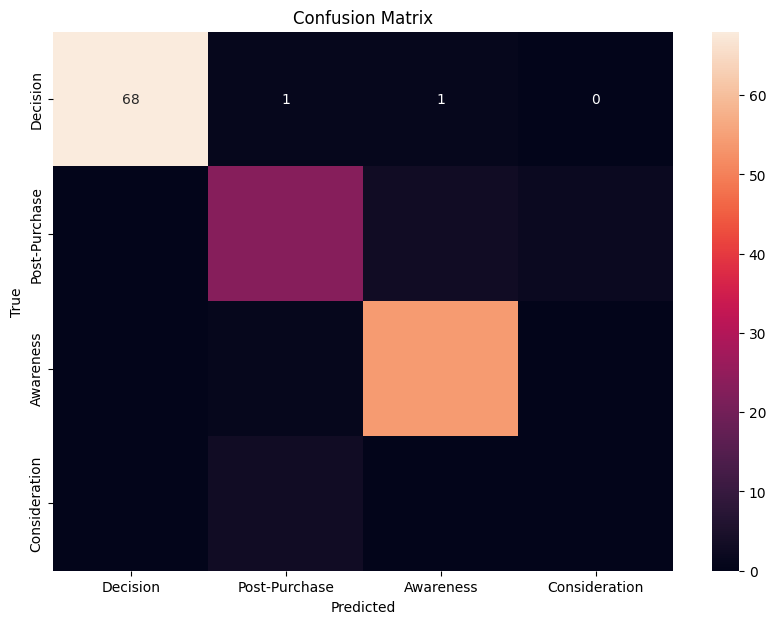

In [4]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import multiprocessing

# Ensure correct device usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "dataset_with_topic_labels.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Define the stage classification logic
def classify_stage(row):
    overlap = row["topics_overlap"]
    topic = row["topic_label"]
    sentiment = row["sentiment"]
    emotional_tone = row["final_consolidated_emotional_tone"]

    if overlap >= 0.2:
        return "Post-Purchase"
    if 0.1 <= overlap < 0.2:
        if topic in ["Connectivity & Portability", "Quality & Reviews"]:
            return "Consideration"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"
    if overlap < 0.1:
        if topic in ["Design & Usability", "Protection & Packaging"]:
            return "Awareness"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"

    if emotional_tone == "Positive" and sentiment == "Positive":
        return "Post-Purchase"
    elif emotional_tone == "Neutral" or sentiment == "Neutral":
        return "Consideration"
    elif emotional_tone == "Negative" or sentiment == "Negative":
        return "Decision"
    elif emotional_tone == "Mixed":
        return "Awareness"

    return "Awareness"

# Apply classification logic
df["stage"] = df.apply(classify_stage, axis=1)

# Map labels to numerical values
label_map = {label: i for i, label in enumerate(df["stage"].unique())}
df["stage_label"] = df["stage"].map(label_map)
print("Label Map:", label_map)

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["processed_text"], df["stage_label"], test_size=0.2, random_state=42
)

# Load tokenizer and model
#model_name = "meta-llama/Llama-3.2-3B"  # Replace with a smaller model for debugging if needed
#tokenizer = AutoTokenizer.from_pretrained(model_name)


model_name="meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("Added padding token '[PAD]' to tokenizer.")

# Load model and resize token embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_map)
).to(device)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Define a global function for tokenization
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=256)

# Parallel tokenization using the global function
def parallel_tokenize(texts):
    with multiprocessing.Pool(processes=8) as pool:  # Adjust process count based on resources
        tokenized = pool.map(tokenize_function, texts)
    return {
        key: torch.tensor([item[key] for item in tokenized])
        for key in tokenized[0]
    }

# Perform tokenization
train_encodings = parallel_tokenize(train_texts.tolist())  # Convert to list for multiprocessing
val_encodings = parallel_tokenize(val_texts.tolist())

train_encodings["labels"] = torch.tensor(train_labels.tolist())
val_encodings["labels"] = torch.tensor(val_labels.tolist())

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_encodings)
val_dataset = Dataset.from_dict(val_encodings)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,  # Optimized batch size
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,  # Simulate larger batch size
    fp16=True,  # Enable mixed precision training
    optim="adamw_bnb_8bit",  # Efficient optimizer
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Analyze performance for a specific class
y_true = val_labels.tolist()
y_pred = trainer.predict(val_dataset).predictions.argmax(-1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


LLAMA 3.2 8b

In [5]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import multiprocessing

# Ensure correct device usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "dataset_with_topic_labels.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Define the stage classification logic
def classify_stage(row):
    overlap = row["topics_overlap"]
    topic = row["topic_label"]
    sentiment = row["sentiment"]
    emotional_tone = row["final_consolidated_emotional_tone"]

    if overlap >= 0.2:
        return "Post-Purchase"
    if 0.1 <= overlap < 0.2:
        if topic in ["Connectivity & Portability", "Quality & Reviews"]:
            return "Consideration"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"
    if overlap < 0.1:
        if topic in ["Design & Usability", "Protection & Packaging"]:
            return "Awareness"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"

    if emotional_tone == "Positive" and sentiment == "Positive":
        return "Post-Purchase"
    elif emotional_tone == "Neutral" or sentiment == "Neutral":
        return "Consideration"
    elif emotional_tone == "Negative" or sentiment == "Negative":
        return "Decision"
    elif emotional_tone == "Mixed":
        return "Awareness"

    return "Awareness"

# Apply classification logic
df["stage"] = df.apply(classify_stage, axis=1)

# Map labels to numerical values
label_map = {label: i for i, label in enumerate(df["stage"].unique())}
df["stage_label"] = df["stage"].map(label_map)
print("Label Map:", label_map)

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["processed_text"], df["stage_label"], test_size=0.2, random_state=42
)

# Load tokenizer and model
#model_name = "meta-llama/Llama-3.2-3B"  # Replace with a smaller model for debugging if needed
#tokenizer = AutoTokenizer.from_pretrained(model_name)


model_name="voidful/Llama-3.2-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Add a padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("Added padding token '[PAD]' to tokenizer.")

# Load model and resize token embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_map)
).to(device)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Define a global function for tokenization
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=256)

# Parallel tokenization using the global function
def parallel_tokenize(texts):
    with multiprocessing.Pool(processes=8) as pool:  # Adjust process count based on resources
        tokenized = pool.map(tokenize_function, texts)
    return {
        key: torch.tensor([item[key] for item in tokenized])
        for key in tokenized[0]
    }

# Perform tokenization
train_encodings = parallel_tokenize(train_texts.tolist())  # Convert to list for multiprocessing
val_encodings = parallel_tokenize(val_texts.tolist())

train_encodings["labels"] = torch.tensor(train_labels.tolist())
val_encodings["labels"] = torch.tensor(val_labels.tolist())

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_encodings)
val_dataset = Dataset.from_dict(val_encodings)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,  # Optimized batch size
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,  # Simulate larger batch size
    fp16=True,  # Enable mixed precision training
    optim="adamw_bnb_8bit",  # Efficient optimizer
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Analyze performance for a specific class
y_true = val_labels.tolist()
y_pred = trainer.predict(val_dataset).predictions.argmax(-1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Using device: cuda
Label Map: {'Decision': 0, 'Post-Purchase': 1, 'Awareness': 2, 'Consideration': 3}


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Added padding token '[PAD]' to tokenizer.


config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/2.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at voidful/Llama-3.2-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/local_scratch/slurm.1723009/ipykernel_4028131/324475308.py:141: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting training...


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/transformers/models/llama/modeling_llama.py", line 919, in forward
    transformer_outputs = self.model(
                          ^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/transformers/models/llama/modeling_llama.py", line 589, in forward
    layer_outputs = decoder_layer(
                    ^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/transformers/models/llama/modeling_llama.py", line 348, in forward
    hidden_states = self.mlp(hidden_states)
                    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/transformers/models/llama/modeling_llama.py", line 186, in forward
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/modules/activation.py", line 432, in forward
    return F.silu(input, inplace=self.inplace)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spati/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2380, in silu
    return torch._C._nn.silu(input)
           ^^^^^^^^^^^^^^^^^^^^^^^^
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 79.10 GiB of which 156.00 MiB is free. Including non-PyTorch memory, this process has 78.93 GiB memory in use. Of the allocated memory 73.35 GiB is allocated by PyTorch, and 139.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
